In [20]:
# %% [markdown]
# # Classics Only: SARIMAX & ETS (HAI & Housing Starts) with Caching

# %%
import os, json, warnings
from pathlib import Path
from typing import List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Config ---
DATA_PATH      = "data/housing_adequacy_dataset.csv"
CACHE_DIR      = Path("model_cache_classics")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

SPLIT_POINT    = "2020Q1"     # train < split, test >= split
RANDOM_STATE   = 42
SEASONALITY_Q  = 4            # quarterly
TARGETS        = ["starts_saar_q", "hai"]

PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia"
}

sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams["figure.dpi"] = 120

# Warnings (quiet down)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [21]:
# %% [code]
def mae(y_true, y_pred):  return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))
def smape(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return float(np.mean(2.0*np.abs(y_pred - y_true)/denom))

def mase(y_true, y_pred, y_train, seasonality=SEASONALITY_Q):
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality: return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) else np.nan
    if scale == 0 or np.isnan(scale): return np.nan
    return mae(y_true, y_pred) / scale

def _to_dt(q):
    import pandas as pd
    if isinstance(q, (pd.PeriodIndex, pd.Index)) and getattr(q, "freq", None) is not None:
        return q.to_timestamp()
    if isinstance(q, pd.Series):
        if pd.api.types.is_period_dtype(q.dtype):
            return q.dt.to_timestamp()
        return pd.to_datetime(q, errors="coerce")
    return pd.to_datetime(q, errors="coerce")

def chrono_split(dfX: pd.DataFrame, split_point: str):
    tr = dfX[dfX["quarter"] < split_point].copy()
    te = dfX[dfX["quarter"] >= split_point].copy()
    return tr, te

# --- cache helpers ---
def _cache_path(key: str) -> Path:
    safe = key.replace("/", "_")
    return CACHE_DIR / f"{safe}.json"

def load_cache(key: str) -> Optional[dict]:
    p = _cache_path(key)
    if p.exists():
        try: return json.loads(p.read_text())
        except Exception: return None
    return None

def save_cache(key: str, value: dict):
    _cache_path(key).write_text(json.dumps(value, indent=2))


Raw shape: (1573, 9)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai
0,1990Q1,ab,2520056.0,23.421667,5.855417,5855.416667,NaN,NaN,0.000000
1,1990Q2,ab,2532621.0,21.490333,5.372583,5372.583333,12565.0,5026.0,1.068958
2,1990Q3,ab,2547788.0,13.847000,3.461750,3461.750000,15167.0,6066.8,0.570606
3,1990Q4,ab,2563142.0,11.723333,2.930833,2930.833333,15354.0,6141.6,0.477210
4,1991Q1,ab,2572947.0,8.494667,2.123667,2123.666667,9805.0,3922.0,0.541475


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.Pe

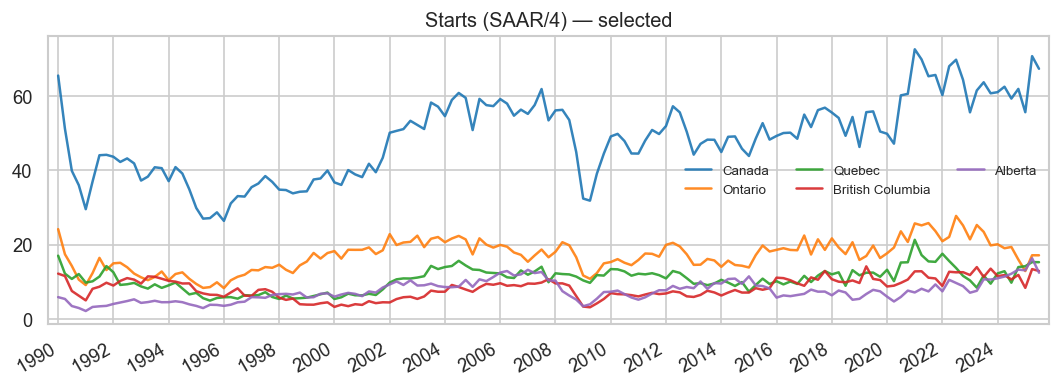

/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.Pe

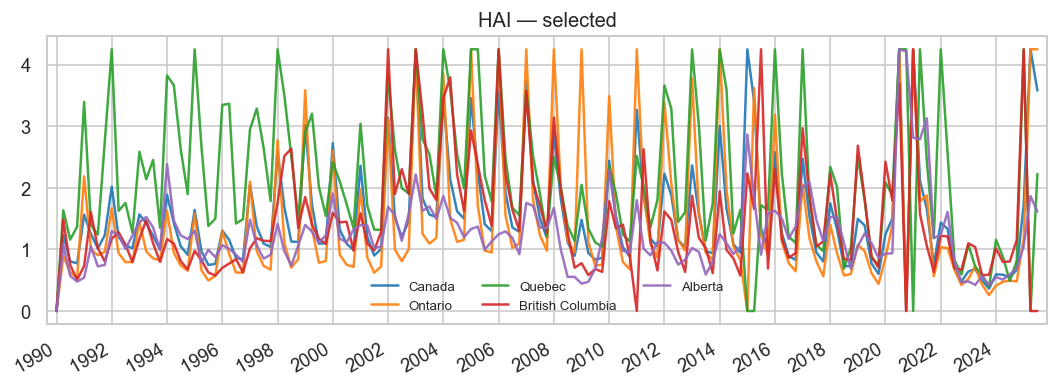

In [22]:
# %% [code]
assert os.path.exists(DATA_PATH), f"Missing {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

print("Raw shape:", df.shape)
display(df.head())

def quick_overlay(df, col, provinces=None, title=None):
    provinces = provinces or PROVINCES_ORDER
    plt.figure(figsize=(9,3.4))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        if sub.empty or col not in sub: continue
        plt.plot(_to_dt(sub["quarter"]), sub[col], lw=1.5, alpha=0.9, label=PROVINCE_NAMES.get(p,p))
    plt.title(title or col); plt.margins(x=0.01)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    if len(provinces)<=6: plt.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

quick_overlay(df, "starts_saar_q", ["can","on","qc","bc","ab"], "Starts (SAAR/4) — selected")
if "hai" in df.columns:
    quick_overlay(df, "hai", ["can","on","qc","bc","ab"], "HAI — selected")


In [23]:
# %% [code]
def add_lags(df, cols: List[str], lags: List[int]) -> pd.DataFrame:
    out = df.sort_values(["province","quarter"]).copy()
    for col in cols:
        for l in lags:
            out[f"{col}_lag{l}"] = out.groupby("province")[col].shift(l)
    return out

def add_calendar(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["year"] = out["quarter"].dt.year
    qnum = out["quarter"].dt.quarter
    q_dummies = pd.get_dummies(qnum, prefix="q", drop_first=True)
    return pd.concat([out, q_dummies], axis=1)

def add_rollings(df: pd.DataFrame, cols=("starts_saar_q","needed_units_q"), windows=(4,)):
    out = df.copy()
    for c in cols:
        for w in windows:
            out[f"{c}_ma{w}"] = out.groupby("province")[c] \
                .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
    return out

def sanitize(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out

# Build exogenous features once
base = add_lags(df, ["pop_change_q","needed_units_q"], lags=[1,4])
base = add_calendar(base)
base = add_rollings(base, cols=("starts_saar_q","needed_units_q"), windows=(4,))
base["province_code"] = base["province"].astype("category").cat.codes
feat = sanitize(base)

# Exog for SARIMAX (drivers only; no target lags)
EXOG_STARTS = [
    "pop_change_q","needed_units_q",
    "pop_change_q_lag1","needed_units_q_lag1",
    "year","q_2","q_3","q_4",
    "starts_saar_q_ma4","needed_units_q_ma4"
]
# For HAI, we can also include housing starts moving average as a driver
EXOG_HAI = [
    "pop_change_q","needed_units_q",
    "pop_change_q_lag1","needed_units_q_lag1",
    "year","q_2","q_3","q_4",
    "starts_saar_q_ma4","needed_units_q_ma4"
]

print("Feature table:", feat.shape)
display(feat.tail(3))


Feature table: (1573, 20)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,pop_change_q_lag1,pop_change_q_lag4,needed_units_q_lag1,needed_units_q_lag4,year,q_2,q_3,q_4,starts_saar_q_ma4,needed_units_q_ma4,province_code
1570,2025Q1,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,9115.0,8164.0,3646.0,3265.6,2025,False,False,False,1.075167,3483.1,10
1571,2025Q2,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,4541.0,8275.0,1816.4,3310.0,2025,True,False,False,1.246375,3120.8,10
1572,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578,3013.0,9277.0,1205.2,3710.8,2025,False,True,False,1.407958,2594.6,10


In [24]:
# %% [code]
def sarimax_grid_small():
    # Tiny but useful grid; widen later if needed
    ps, ds, qs = [0,1], [0,1], [0,1]
    Ps, Ds, Qs = [0,1], [0,1], [0,1]
    orders = [(p,d,q) for p in ps for d in ds for q in qs]
    seas   = [(P,D,Q,SEASONALITY_Q) for P in Ps for D in Ds for Q in Qs]
    return orders, seas

def fit_sarimax_best(y_train: pd.Series,
                     exog_train: Optional[pd.DataFrame] = None,
                     y_val: Optional[pd.Series] = None,
                     exog_val: Optional[pd.DataFrame] = None,
                     cache_key: Optional[str] = None):
    """Search SARIMAX on a small grid, MAE on validation (last 4–20% of train)."""
    # cache
    cache = load_cache(cache_key) if cache_key else None
    if cache and "order" in cache and "seasonal_order" in cache:
        order = tuple(cache["order"]); seasonal_order = tuple(cache["seasonal_order"])
        mod = SARIMAX(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit(disp=False)
        return res, order, seasonal_order, True

    orders, seas = sarimax_grid_small()
    best = None; best_tuple = None
    for order in orders:
        for seasonal_order in seas:
            try:
                mod = SARIMAX(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                              enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False)
                if y_val is not None:
                    pred = res.predict(start=y_val.index[0], end=y_val.index[-1], exog=exog_val)
                    score = mae(y_val, pred)
                else:
                    pred = res.fittedvalues
                    score = mae(y_train, pred)
                if (best is None) or (score < best):
                    best = score; best_tuple = (order, seasonal_order, res)
            except Exception:
                continue

    if best_tuple is None:
        # fallback basic ARIMA(1,0,0) no season
        order=(1,0,0); seasonal_order=(0,0,0,SEASONALITY_Q)
        res = SARIMAX(y_train, exog=exog_train, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
        if cache_key: save_cache(cache_key, {"order": order, "seasonal_order": seasonal_order})
        return res, order, seasonal_order, False

    order, seasonal_order, res = best_tuple
    if cache_key: save_cache(cache_key, {"order": order, "seasonal_order": seasonal_order})
    return res, order, seasonal_order, False

def fit_ets_best(y_train: pd.Series, cache_key: Optional[str] = None):
    """Search a few ETS configs (trend/seasonal add/mul)."""
    cache = load_cache(cache_key) if cache_key else None
    if cache and "trend" in cache and "seasonal" in cache:
        tr, se = cache["trend"], cache["seasonal"]
        mod = ExponentialSmoothing(y_train, trend=tr, seasonal=se,
                                   seasonal_periods=SEASONALITY_Q, initialization_method="estimated")
        res = mod.fit(optimized=True)
        return res, tr, se, True

    cands = [("add","add"), ("add","mul"), ("mul","add"), ("mul","mul")]
    best=None; best_cfg=None
    for tr, se in cands:
        try:
            mod = ExponentialSmoothing(y_train, trend=tr, seasonal=se,
                                       seasonal_periods=SEASONALITY_Q, initialization_method="estimated")
            res = mod.fit(optimized=True)
            score = mae(y_train, res.fittedvalues)
            if (best is None) or (score < best):
                best = score; best_cfg=(tr,se,res)
        except Exception:
            continue

    if best_cfg is None:
        tr,se="add","add"
        mod = ExponentialSmoothing(y_train, trend=tr, seasonal=se,
                                   seasonal_periods=SEASONALITY_Q, initialization_method="estimated")
        res = mod.fit(optimized=True)
        if cache_key: save_cache(cache_key, {"trend": tr, "seasonal": se})
        return res, tr, se, False

    tr,se,res = best_cfg
    if cache_key: save_cache(cache_key, {"trend": tr, "seasonal": se})
    return res, tr, se, False


In [25]:
# %% [code]
MODEL_COLORS = {"sarimax": "#4c72b0", "ets": "#55a868"}

def plot_overlay_train_test(x_tr, y_tr, x_te, y_te,
                            yhat_tr_dict, yhat_te_dict,
                            title, ylabel):
    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    # Actual
    ax.plot(x_tr, y_tr, color="black", lw=2, label="Actual (train)")
    ax.plot(x_te, y_te, color="black", lw=2, label="Actual (test)")
    # Models
    for name, yhat in yhat_tr_dict.items():
        color = MODEL_COLORS.get(name.lower(), None)
        ax.plot(x_tr, yhat, lw=1, color=color, label=f"{name} (train)")
    for name, yhat in yhat_te_dict.items():
        color = MODEL_COLORS.get(name.lower(), None)
        ax.plot(x_te, yhat, lw=1, ls="--", color=color, label=f"{name} (test)")
    ax.axvline(x_te.min(), color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(title); ax.set_ylabel(ylabel); ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def plot_model_bars(metrics_df: pd.DataFrame, title="MASE by model"):
    tmp = metrics_df.copy()
    if "province" not in tmp.columns:
        tmp["province"] = "pooled"
    plt.figure(figsize=(10,4))
    sns.barplot(data=tmp, x="province", y="MASE", hue="model")
    plt.axhline(1.0, color="gray", ls="--", lw=1, alpha=0.7)
    plt.title(title); plt.xlabel(""); plt.ylabel("MASE (lower better)")
    plt.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()


In [26]:
# %% [code]
def run_per_province_classics(feat_df: pd.DataFrame,
                              target: str,
                              exog_cols: List[str],
                              include_ets: bool = True,
                              include_sarimax: bool = True):
    results = []
    preds_store = {}
    provinces = [p for p in PROVINCES_ORDER if p in feat_df["province"].unique()]

    for p in provinces:
        sub = feat_df[feat_df["province"]==p].dropna(subset=[target]).copy()
        if sub.empty: continue
        tr, te = chrono_split(sub, SPLIT_POINT)
        if tr.empty or te.empty: continue

        # y_tr = tr[target].copy()
        # y_te = te[target].copy()
        y_tr, y_te = tr[target], te[target]
        

        # exog (drivers only)
        use_exog = [c for c in exog_cols if c in sub.columns]
        # ex_tr = tr[use_exog] if use_exog else None
        # ex_te = te[use_exog] if use_exog else None
        ex_tr = tr[exog_cols] if exog_cols else None
        ex_te = te[exog_cols] if exog_cols else None

        x_tr = _to_dt(tr["quarter"]); x_te = _to_dt(te["quarter"])
        yhat_tr_dict, yhat_te_dict = {}, {}
        preds_store.setdefault(p, {})

        # --- SARIMAX ---
        if include_sarimax:
            val_cut = max(4, int(len(y_tr)*0.2))
            sarikey = f"SARIMAX|{target}|{p}"
            sar_res, ord_, s_ord_, sar_cached = fit_sarimax_best(
                y_train=pd.Series(y_tr.values, index=tr.index[:-0]) if len(y_tr)>0 else y_tr,
                exog_train=ex_tr,
                y_val=pd.Series(y_tr.values[-val_cut:], index=tr.index[-val_cut:]) if len(y_tr)>val_cut else None,
                exog_val=ex_tr.iloc[-val_cut:] if (ex_tr is not None and len(y_tr)>val_cut) else None,
                cache_key=sarikey
            )
            # refit on full train
            sar_res = SARIMAX(y_tr, exog=ex_tr, order=ord_, seasonal_order=s_ord_,
                              enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            sar_tr = sar_res.fittedvalues
            sar_te = sar_res.predict(start=te.index[0], end=te.index[-1], exog=ex_te)

            results.append({
                "province": p, "target": target, "model": "sarimax",
                "MAE": mae(y_te, sar_te), "RMSE": rmse(y_te, sar_te),
                "sMAPE(%)": smape(y_te, sar_te)*100,
                "MASE": mase(y_te, sar_te, y_train=y_tr, seasonality=SEASONALITY_Q),
                "R2_test": float(np.corrcoef(y_te, sar_te)[0,1]**2) if len(y_te)>1 else np.nan,
                "params": {"order": ord_, "seasonal_order": s_ord_, "cached": sar_cached}
            })
            preds_store[p]["sarimax"] = {"idx_tr": tr.index, "idx_te": te.index,
                                         "y_tr": y_tr.values, "y_te": y_te.values,
                                         "yhat_tr": np.asarray(sar_tr), "yhat_te": np.asarray(sar_te)}
            yhat_tr_dict["sarimax"] = np.asarray(sar_tr)
            yhat_te_dict["sarimax"] = np.asarray(sar_te)

        # --- ETS (Holt-Winters) ---
        if include_ets:
            etsk = f"ETS|{target}|{p}"
            ets_res, trd, seas, ets_cached = fit_ets_best(pd.Series(y_tr.values, index=tr.index), cache_key=etsk)
            ets_tr = ets_res.fittedvalues
            ets_te = ets_res.predict(start=te.index[0], end=te.index[-1])

            results.append({
                "province": p, "target": target, "model": "ets",
                "MAE": mae(y_te, ets_te), "RMSE": rmse(y_te, ets_te),
                "sMAPE(%)": smape(y_te, ets_te)*100,
                "MASE": mase(y_te, ets_te, y_train=y_tr, seasonality=SEASONALITY_Q),
                "R2_test": float(np.corrcoef(y_te, ets_te)[0,1]**2) if len(y_te)>1 else np.nan,
                "params": {"trend": trd, "seasonal": seas, "cached": ets_cached}
            })
            preds_store[p]["ets"] = {"idx_tr": tr.index, "idx_te": te.index,
                                     "y_tr": y_tr.values, "y_te": y_te.values,
                                     "yhat_tr": np.asarray(ets_tr), "yhat_te": np.asarray(ets_te)}
            yhat_tr_dict["ets"] = np.asarray(ets_tr)
            yhat_te_dict["ets"] = np.asarray(ets_te)

        # Overlay for this province/target
        ylabel = target + (" (thousands/quarter)" if target=="starts_saar_q" else "")
        title = f"{PROVINCE_NAMES.get(p,p)} — {target} (train solid / test dashed)"
        plot_overlay_train_test(x_tr, y_tr, x_te, y_te, yhat_tr_dict, yhat_te_dict, title, ylabel)

    met = pd.DataFrame(results).sort_values(["province","RMSE"]).reset_index(drop=True)
    return met, preds_store

def _prefer_can_or_aggregate(dfX: pd.DataFrame, target: str):
    """Return national series (Index: PeriodIndex) — prefer 'can' rows if present, else sum over provinces."""
    if "can" in dfX["province"].unique():
        ser = dfX[dfX["province"]=="can"].set_index("quarter")[target]
        return ser
    # else aggregate sum for starts, mean for HAI
    if target == "starts_saar_q":
        ser = dfX.groupby("quarter")[target].sum()
    else:
        ser = dfX.groupby("quarter")[target].mean()
    return ser

def run_pooled_national_classics(feat_df: pd.DataFrame,
                                 target: str,
                                 exog_cols: List[str],
                                 include_ets: bool = True,
                                 include_sarimax: bool = True):
    """National series (prefer CAN row; else aggregate) + optional exogenous drivers (aggregated similarly)."""
    # national target series
    ser_all = _prefer_can_or_aggregate(feat_df, target)
    idx_df = pd.DataFrame({"quarter": ser_all.index})
    full = idx_df.merge(feat_df[["quarter"]+exog_cols].drop_duplicates(), on="quarter", how="left")

    tr_mask = ser_all.index < pd.Period(SPLIT_POINT, freq="Q")
    te_mask = ser_all.index >= pd.Period(SPLIT_POINT, freq="Q")
    y_tr = ser_all[tr_mask]; y_te = ser_all[te_mask]

    ex_tr = full.set_index("quarter").loc[y_tr.index, exog_cols] if exog_cols else None
    ex_te = full.set_index("quarter").loc[y_te.index, exog_cols] if exog_cols else None

    results = []
    preds_store = {"pooled": {}}

    x_tr = _to_dt(pd.PeriodIndex(y_tr.index, freq="Q"))
    x_te = _to_dt(pd.PeriodIndex(y_te.index, freq="Q"))
    yhat_tr_dict, yhat_te_dict = {}, {}

    # SARIMAX national
    if include_sarimax:
        # hold out last ~20% (min 4 pts) of TRAIN for model selection
        val_cut = max(4, int(len(y_tr) * 0.20))
        use_val = len(y_tr) > val_cut

        if use_val:
            y_train_fit  = y_tr.iloc[:-val_cut]
            y_val        = y_tr.iloc[-val_cut:]
            ex_train_fit = ex_tr.iloc[:-val_cut] if ex_tr is not None else None
            ex_val       = ex_tr.iloc[-val_cut:] if ex_tr is not None else None
        else:
            y_train_fit  = y_tr
            y_val        = None
            ex_train_fit = ex_tr
            ex_val       = None

        sarikey = f"SARIMAX|{target}|{p}"

        sar_res_sel, ord_, s_ord_, sar_cached = fit_sarimax_best(
            y_train   = y_train_fit,      # <-- keeps index (no [: -0])
            exog_train= ex_train_fit,
            y_val     = y_val,
            exog_val  = ex_val,
            cache_key = sarikey
        )

        # Refit on FULL train with chosen orders
        sar_res = SARIMAX(
            y_tr, exog=ex_tr,
            order=ord_, seasonal_order=s_ord_,
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False)

        # In-sample fit and out-of-sample predict with aligned indices
        sar_tr = sar_res.fittedvalues
        sar_te = sar_res.predict(start=te.index[0], end=te.index[-1], exog=ex_te)

        results.append({
            "province": p, "target": target, "model": "sarimax",
            "MAE": mae(y_te, sar_te), "RMSE": rmse(y_te, sar_te),
            "sMAPE(%)": smape(y_te, sar_te)*100,
            "MASE": mase(y_te, sar_te, y_train=y_tr, seasonality=SEASONALITY_Q),
            "R2_test": float(np.corrcoef(y_te, sar_te)[0,1]**2) if len(y_te)>1 else np.nan,
            "params": {"order": ord_, "seasonal_order": s_ord_, "cached": sar_cached}
        })

        preds_store.setdefault(p, {})["sarimax"] = {
            "idx_tr": tr.index, "idx_te": te.index,
            "y_tr": y_tr.values, "y_te": y_te.values,
            "yhat_tr": np.asarray(sar_tr.reindex(tr.index)),     # align to tr index
            "yhat_te": np.asarray(sar_te.reindex(te.index))      # align to te index
        }
        yhat_tr_dict["sarimax"] = np.asarray(sar_tr.reindex(tr.index))
        yhat_te_dict["sarimax"] = np.asarray(sar_te.reindex(te.index))

    # ETS national
    if include_ets:
        etsk = f"ETS|{target}|NATIONAL"
        ets_res, trd, seas, ets_cached = fit_ets_best(y_tr, cache_key=etsk)
        ets_tr = ets_res.fittedvalues
        ets_te = ets_res.predict(start=y_te.index[0], end=y_te.index[-1])

        results.append({
            "province":"pooled", "target": target, "model": "ets_nat",
            "MAE": mae(y_te, ets_te), "RMSE": rmse(y_te, ets_te),
            "sMAPE(%)": smape(y_te, ets_te)*100,
            "MASE": np.nan,
            "R2_test": float(np.corrcoef(y_te, ets_te)[0,1]**2) if len(y_te)>1 else np.nan,
            "params": {"trend": trd, "seasonal": seas, "cached": ets_cached}
        })
        preds_store["pooled"]["ets_nat"] = {
            "quarter_tr": y_tr.index, "quarter_te": y_te.index,
            "y_tr": y_tr.values, "y_te": y_te.values,
            "yhat_tr": np.asarray(ets_tr), "yhat_te": np.asarray(ets_te)
        }
        yhat_tr_dict["ets"] = np.asarray(ets_tr)
        yhat_te_dict["ets"] = np.asarray(ets_te)

    # Plot national overlay
    ylabel = target + (" (thousands/quarter)" if target=="starts_saar_q" else "")
    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    ax.plot(x_tr, y_tr, color="black", lw=2, label="Actual (train)")
    ax.plot(x_te, y_te, color="black", lw=2, label="Actual (test)")
    for name, yhat in yhat_tr_dict.items():
        ax.plot(x_tr, yhat, lw=1, color=MODEL_COLORS.get(name,"#444"), label=f"{name}_nat (train)")
    for name, yhat in yhat_te_dict.items():
        ax.plot(x_te, yhat, lw=1, ls="--", color=MODEL_COLORS.get(name,"#444"), label=f"{name}_nat (test)")
    ax.axvline(x_te.min(), color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(f"Pooled/National — {target} (classical)")
    ax.set_ylabel(ylabel); ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

    met = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
    return met, preds_store


In [27]:
# %% [code]
per_metrics_starts, per_preds_starts = run_per_province_classics(
    feat_df=feat,
    target="starts_saar_q",
    exog_cols=EXOG_STARTS,
    include_ets=True,
    include_sarimax=True
)
display(per_metrics_starts.head(22))

pool_metrics_starts, pool_preds_starts = run_pooled_national_classics(
    feat_df=feat,
    target="starts_saar_q",
    exog_cols=EXOG_STARTS,
    include_ets=True,
    include_sarimax=True
)
display(pool_metrics_starts.head(12))


/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):
/var/folders/8y/55dw_cwj3hv6wylylp7fwhb80000gn/T/ipykernel_16612/3651054790.py:22: DeprecationWarning: is_period_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.PeriodDtype)` instead
  if pd.api.types.is_period_dtype(q.dtype):


ValueError: Length of values (120) does not match length of index (0)